I used the [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1) on Kaggle to predict fruad transactions using different machine learning techniques.


In [3]:
# Read file from Google Drive
import zipfile
local_zip = '/content/drive/My Drive/kaggle_fraud_detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import pandas as pd
from sklearn.compose import ColumnTransformer
import numpy as np 
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
sns.set_style("dark")

from sklearn import preprocessing
from scipy.stats import skew, boxcox

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Read the data file
data = pd.read_csv("/content/PS_20174392719_1491204439457_log.csv")

In [6]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [7]:
# Check for NA values
data.isnull().values.any()

False

# Exploratory Data Analysis 

In [8]:
# Different type of transactions and their counts
data['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

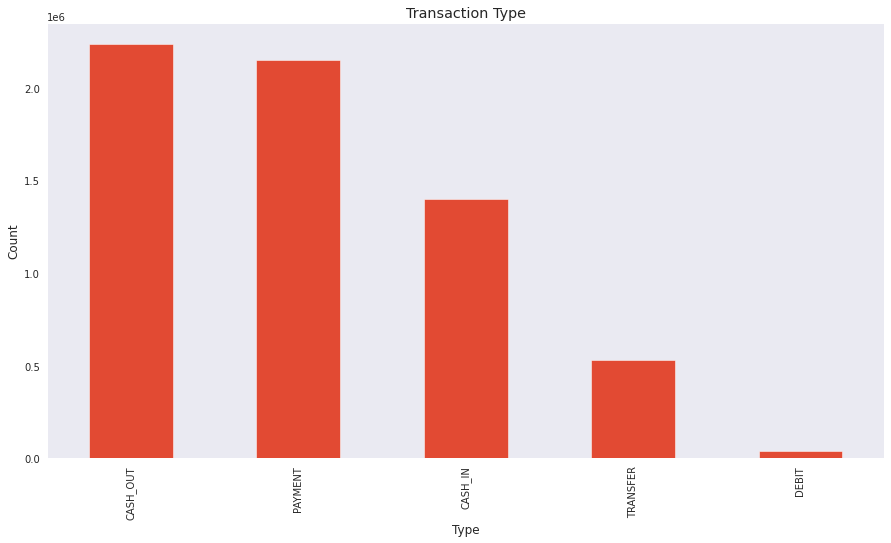

In [9]:
plt.figure(figsize=(15,8))
plt.xlabel("Type")
plt.ylabel("Count")
data.type.value_counts().plot(kind='bar', title= "Transaction Type")
plt.show()

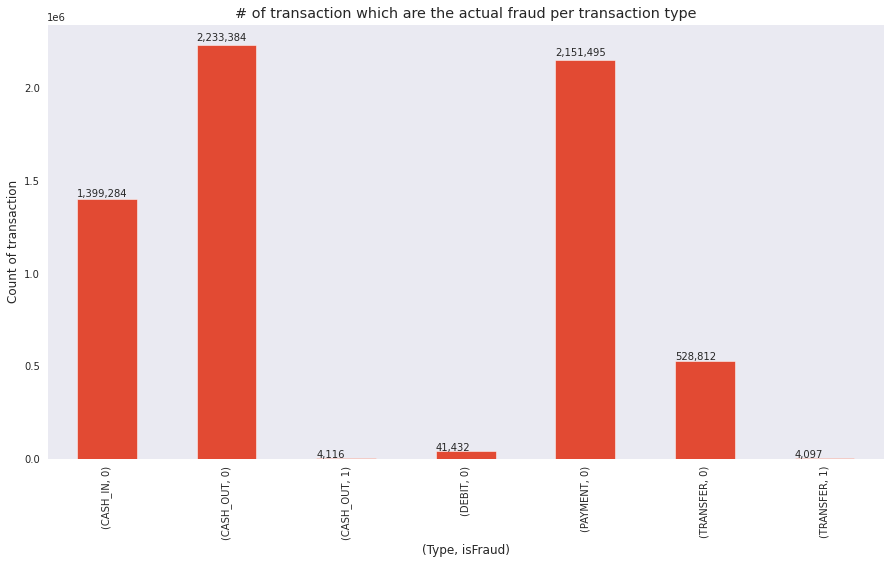

In [10]:
# What are the transaction type when fraud occurs?
plt.figure(figsize=(15,8))
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

The frauds in the dataset are either "cash out" or "debit". I will keep only these 2 types for modeling.

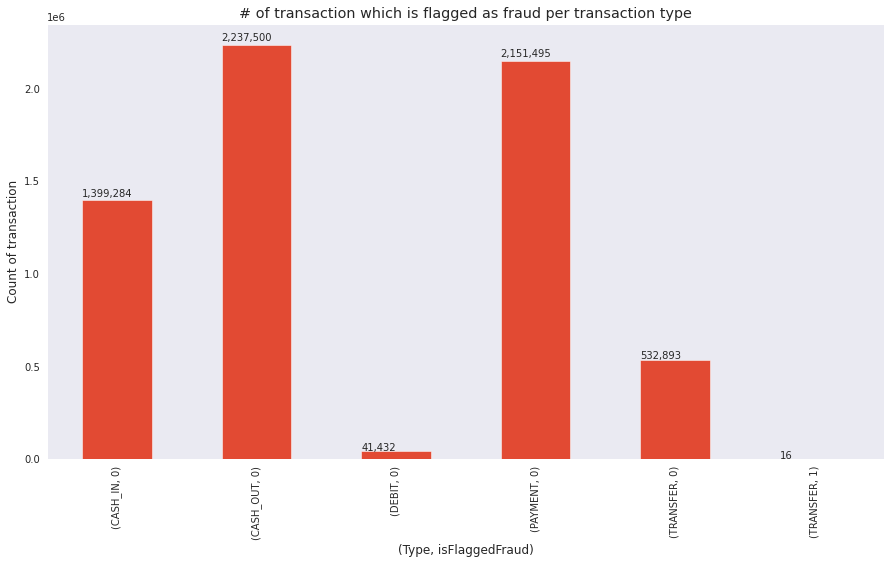

In [11]:
# What type of transactions were flagged as fraud?
plt.figure(figsize=(15,8))
ax = data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

The system only flagged fraud transactions in "Transer".

In [13]:
# Keep only 'TRANSFER' and 'CASH_OUT', drop columns I don't need
# Convert categorical variables to numeric variable
from statsmodels.tools import categorical
tmp = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT'])),:]
tmp.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1, inplace = True)
tmp = tmp.reset_index(drop = True)
a = np.array(tmp['type'])
b = categorical(a, drop = True)
tmp['type_num'] = b.argmax(1)

print(tmp.head(3))

       type     amount  oldbalanceOrg  ...  newbalanceDest  isFraud  type_num
0  TRANSFER     181.00          181.0  ...            0.00        1         1
1  CASH_OUT     181.00          181.0  ...            0.00        1         0
2  CASH_OUT  229133.94        15325.0  ...        51513.44        0         0

[3 rows x 8 columns]


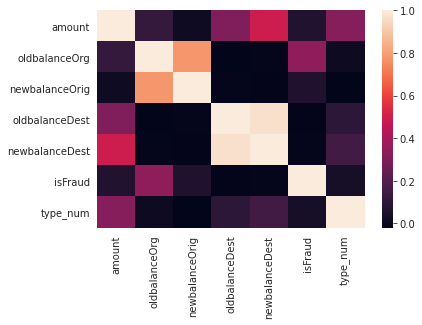

In [14]:
sns.heatmap(tmp.corr())



1.   oldbalanceOrg is highly correalated to newbalanceOrig
2.   oldbalanceDest is highly correlated to newbalanceDest
3.   newbalanceDest is correlated to amount



In [15]:
# Box Cox Transformation to transform non-normal dependent variables into a normal shape
tmp['amount_boxcox'] = preprocessing.scale(boxcox(tmp['amount']+1)[0])
tmp['oldbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceOrg']+1)[0])
tmp['newbalanceOrg_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceOrig']+1)[0])
tmp['oldbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['oldbalanceDest']+1)[0])
tmp['newbalanceDest_boxcox'] = preprocessing.scale(boxcox(tmp['newbalanceDest']+1)[0])

In [16]:
print("The fraud transaction of the filtered dataset: {0:.4f}%".format((len(tmp[tmp.isFraud == 1])/len(tmp)) * 100))

The fraud transaction of the filtered dataset: 0.2965%


# Deal with imbalance data

There are less than 0.3% of fraud data in this dataset, which is extremely imbalance.

Most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

I use SMOTE (Synthetic Minority Oversampling Technique) to oversampling the minority class, then undersampling the majority class. 

In [17]:
!pip install imbalanced-learn

In [18]:
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from numpy import where
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

In [19]:
tmp.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'amount', 'type'], axis=1, inplace=True)

X = tmp.iloc[:, tmp.columns != 'isFraud']
y = tmp.iloc[:, tmp.columns == 'isFraud']

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

Number transactions train dataset:  1,939,286
Number transactions test dataset:  831,123
Total number of transactions:  2,770,409


In [20]:
# define pipeline
over = SMOTE(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 552438, 1: 276219})


In [21]:
# Dataset after processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("Number transactions train dataset: ", format(len(X_train),',d'))
print("Number transactions test dataset: ", format(len(X_test), ',d'))
print("Total number of transactions: ", format(len(X_train)+len(X_test), ',d'))

Number transactions train dataset:  580,059
Number transactions test dataset:  248,598
Total number of transactions:  828,657


# Modeling

I use the following methods to predict fraud transactions.

1. Random Forest
2. kNN
3. Logistics Regression
4. SVMs

According to [this article](https://perfectial.com/blog/fraud-detection-machine-learning/), random forest has the best performance dealing with financial fraudulence, kNN, logistic regression and SVM are also worthy to try. <br>

Evaluation metric: Recall is more important in this case since it's less harmful to predict fraudulence transaction and turns out to be non-fraudulence (False positive) than False Negative (predicted regular, turns out to be fraud).

## Random Forest

In [28]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [5, 64, 128],
    #'n_estimators': [64, 128],
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': ['auto'],
    'criterion' :['gini']
}
CV_rfc = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, verbose=2)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_features=auto, n_estimators=5, total=   4.5s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


[CV]  criterion=gini, max_features=auto, n_estimators=5, total=   4.7s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, total=   4.7s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, total=   4.8s
[CV] criterion=gini, max_features=auto, n_estimators=5 ...............
[CV]  criterion=gini, max_features=auto, n_estimators=5, total=   4.6s
[CV] criterion=gini, max_features=auto, n_estimators=64 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=64, total=  59.3s
[CV] criterion=gini, max_features=auto, n_estimators=64 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=64, total= 1.1min
[CV] criterion=gini, max_features=auto, n_estimators=64 ..............
[CV]  criterion=gini, max_features=auto, n_estimators=64, total= 1.1min
[CV] criterion=gini, max_features=auto, n_estimators=64 ..............
[CV

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 16.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [29]:
CV_rfc.best_params_

{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 128}

In [31]:
rfc1 = RandomForestClassifier(random_state = 42, max_features='auto', n_estimators= 128, criterion='gini')

In [32]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=128,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

pred = rfc1.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for Random Forest: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for Random Forest: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for Random Forest: ", recall)

[[165509    467]
 [   141  82481]]
Accuracy for Random Forest:  0.997554284427067
Precision for Random Forest:  0.997186340193763
Recall for Random Forest:  0.9991488077271355


## K-Nearest Neighbors

In [37]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = list(range(1,30))

grid_para = {
    'n_neighbors': n_neighbors,
    'weights': ['uniform', 'distance'],
    'metric' :['euclidean', 'manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_para,
    verbose = 2,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 116 candidates, totalling 348 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 54.7min
[Parallel(n_jobs=-1)]: Done 348 out of 348 | elapsed: 130.6min finished


In [38]:
gs_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

In [39]:
KNC = KNeighborsClassifier(metric = 'euclidean', n_neighbors = 1, weights = 'uniform')
KNC.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [40]:
pred = KNC.predict(X_test)

In [41]:
pred = KNC.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for kNN: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for kNN: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for kNN: ", recall)

[[165025    951]
 [   240  82382]]
Accuracy for kNN:  0.9952091328168369
Precision for kNN:  0.9942702559406179
Recall for kNN:  0.9985477868877257


In [42]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    165976
           1       0.99      1.00      0.99     82622

    accuracy                           1.00    248598
   macro avg       0.99      1.00      0.99    248598
weighted avg       1.00      1.00      1.00    248598



## Logistics Regression

In [43]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.510761
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.198      
Dependent Variable: y                AIC:              846503.2773
Date:               2020-10-03 03:23 BIC:              846573.0427
No. Observations:   828657           Log-Likelihood:   -4.2325e+05
Df Model:           5                LL-Null:          -5.2745e+05
Df Residuals:       828651           LLR p-value:      0.0000     
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
x1       -2.2246     0.0088   -253.7173   0.0000   -2.2418   -2.2075
x2        0.6987     0.0033    209.7557   0.0

P-values are all smaller than 0.05, therefore, we keep all of them.

In [45]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
pred = logreg.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for Logistics Regression: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for Logistics Regression: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for Logistics Regression: ", recall)

[[157795   8181]
 [  4873  77749]]
Accuracy for Logistics Regression:  0.9474895212350863
Precision for Logistics Regression:  0.9507097411673977
Recall for Logistics Regression:  0.9700432783337841


In [47]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96    165976
           1       0.90      0.94      0.92     82622

    accuracy                           0.95    248598
   macro avg       0.94      0.95      0.94    248598
weighted avg       0.95      0.95      0.95    248598



## Support Vector Machine

Test simple SVM and kernel SVMs.

In [22]:
from sklearn.svm import SVC 
svclassifier = SVC(kernel='linear', verbose = 2)
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=2)

In [23]:
pred = svclassifier.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for SVM: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for SVM: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for SVM: ", recall)

[[158568   7408]
 [  5311  77311]]
Accuracy for SVM:  0.9488370783353044
Precision for SVM:  0.9553670410179785
Recall for SVM:  0.9675919428358728


### Kernel SVM

Let's test which kernel SVM works best in our case.

1. Polynomial Kernel

In [24]:
svclassifier = SVC(kernel = 'poly', degree=8, verbose = 2)
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=2)

In [25]:
pred = svclassifier.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)

print("Accuracy for Polynomial Kernel SVM: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for Polynomial Kernel SVM: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for Polynomial Kernel SVM: ", recall)

[[164273   1703]
 [ 11787  70835]]
Accuracy for Polynomial Kernel SVM:  0.9457356857255489
Precision for Polynomial Kernel SVM:  0.9897394804068058
Recall for Polynomial Kernel SVM:  0.9330512325343633


2. Gaussian Kernel

In [26]:
svclassifier = SVC(kernel='rbf', verbose = 2)
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=2)

In [27]:
pred = svclassifier.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for Gaussian Kernel SVM: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for Gaussian Kernel SVM: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for Gaussian Kernel SVM: ", recall)

[[163406   2570]
 [   233  82389]]
Accuracy for Gaussian Kernel SVM:  0.9887247685017578
Precision for Gaussian Kernel SVM:  0.9845158336144985
Recall for Gaussian Kernel SVM:  0.9985761340511736


3. Sigmoid Kernel


In [29]:
svclassifier = SVC(kernel='sigmoid', verbose = 2)
svclassifier.fit(X_train, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=2)

In [30]:
pred = svclassifier.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(cm)
print("Accuracy for Sigmoid Kernel SVM: ", accuracy_score(y_test, pred))
precision = cm[0,0] / (cm[0,0] + cm[0,1])
print("Precision for Sigmoid Kernel SVM: ", precision)
recall = cm[0,0] / (cm[0,0] + cm[1,0])
print("Recall for Sigmoid Kernel SVM: ", recall)

[[114888  51088]
 [ 50175  32447]]
Accuracy for Sigmoid Kernel SVM:  0.5926636577929026
Precision for Sigmoid Kernel SVM:  0.6921964621391045
Recall for Sigmoid Kernel SVM:  0.6960251540320969


The Gaussian Kernel SVM has the best accuracy rate among all the SVMs



# Accuracy rate and recall summary

Random Forest:<br>
  Accuracy for Random Forest:  **0.997554**<br>
  Recall for Random Forest:  **0.999148**<br>

kNN:<br>
  Accuracy for kNN:  0.9952091<br>
  Recall for kNN:  0.998547<br>

Logistics Regression:<br>
  Accuracy for Logistics Regression:  0.947489<br>
  Recall for Logistics Regression:  0.970043<br>

SVM:<br>
  Accuracy for Gaussian Kernel SVM:  0.988724<br>
  Recall for Gaussian Kernel SVM:  0.998576<br>


## Conclusion

1.   Random forest has the best accuracy rate and recall score.

2.   The time it takes to train the RF model is reasonable.

3. LSTM is also worth trying in the future if we can overcome the long training time and expensive cost using this method.
